In [1]:
import os
import torch
import datasets.paths as d_path
import torchvision

from engine.lesion_detection_detr import train_one_epoch, evaluate
from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets
from utils.plot import plot_losses
from IPython.display import clear_output
from datasets.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.lesion_detection import check_best, end_train, load_backbone
from models.detr.detr import build_detr

from utils.train import set_weights_trainable
import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
reproducibility()
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large 

In [3]:
from config.dataset import REFLACXLesionDetectionDatasetArgs
from config.model import DETRArgs
from config.training import LesionDetectionArgs

training_args = LesionDetectionArgs(
    name="lesion_detection",
    batch_size=4,
    early_stopping_patience=300,
    learning_rate=1e-4, # 1e-3 not working for CF.
    weight_decay=1e-4,
)
dataset_args = REFLACXLesionDetectionDatasetArgs(
    image_size=128,
)

cl_model_name = "MCL_resnet50_accuracy_0_1433_epoch48_10-08-2023 15-58-25"

configs = [
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=DETRArgs(
    #         name="CL_NoFix",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=5,
    #     ),
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=DETRArgs(
    #         name="CL_Fix5Layers",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=0,
    #     ),
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=DETRArgs(
    #         name="CL_Fix2Layers",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=3,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=DETRArgs(
    #         name="CL_Fix20Epoch",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=0,
    #         release_fixed_weights_after=20,
    #     ),
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=DETRArgs(
    #         name="ImageNet_Fix2Layers",
    #         weights="imagenet",
    #         trainable_backbone_layers=3,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=DETRArgs(
    #         name="ImageNet_Fix5layers",
    #         weights="imagenet",
    #         trainable_backbone_layers=0,
    #     ),
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=DETRArgs(
    #         name="ImageNet_Fix2Layers",
    #         weights="imagenet",
    #         trainable_backbone_layers=3,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=DETRArgs(
    #         name="ImageNet_NoFix",
    #         weights="imagenet",
    #         trainable_backbone_layers=5,
    #     ),
    # ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=DETRArgs(
            name="Random",
            weights=None,
            trainable_backbone_layers=5,
        )
    ),
]

# configs = [
#     ConfigArgs(
#         training=training_args,
#         dataset=dataset_args,
#         model=DETRArgs(
#             name="ImageNet_NoFix",
#             weights="imagenet",
#             trainable_backbone_layers=5,
#         ),
#     ),
# ]

In [4]:
num_epochs = 300  # 200
train_infos: list[TrainingInfo] = []

In [5]:
# # load this one into
# backbone = load_backbone(config, device)
# backbone.body
# model.backbone[0].body = backbone.body

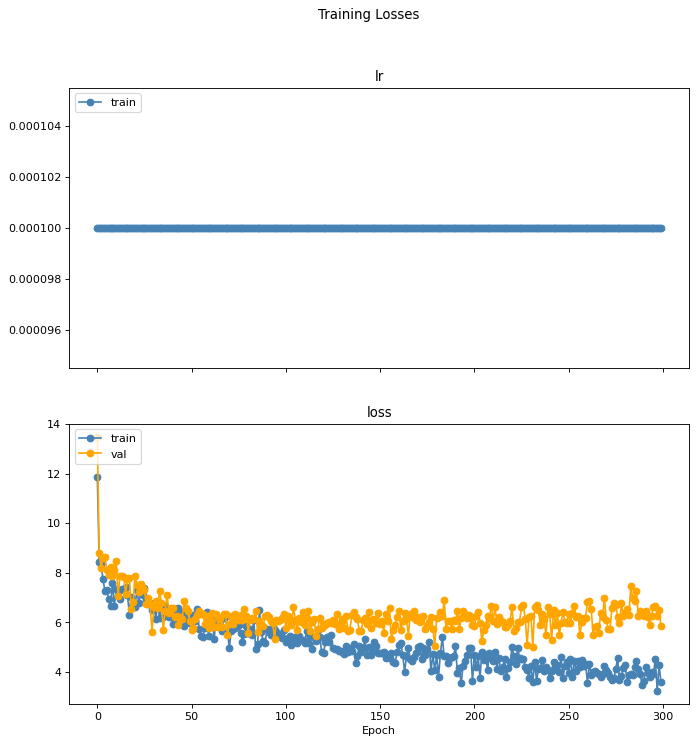

| Epoch [300] Done | It has took [904.40] min, Avg time: [180.88] sec/epoch | Estimate time for [300] epochs: [904.40] min | Epoch took [145.043011] sec |  Patience [67] |
| Training Done, start testing! | [300] Epochs Training time: [54264.292541] seconds, Avg time / Epoch: [180.88097513666668] seconds
========================================For Training [lesion_detection - Random]========================================
LesionDetectionArgs(name='lesion_detection', learning_rate=0.0001, sgd_momentum=0.9, batch_size=4, weight_decay=0.0001, early_stopping_patience=300, warmup_epoch=0)
REFLACXLesionDetectionDatasetArgs(image_size=128, label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'])
DETRArgs(name='Random', weights=None, cl_model_name=None, trainable_backbone_layers=5, release_fixed_weights_after=None, hidden_dim=32, dilation=False, position_embedding='sine', dropout=0.1, nheads=4, dim_feedforward=64, enc_layers=3, dec_l

In [6]:
for config in configs:
    device = clean_memory_get_device()
    reproducibility()

    train_info = TrainingInfo(config)

    model, criterion, postprocessors = build_detr(
        backbone="resnet18",
        train_backbone="true",
        hidden_dim=config.model.hidden_dim,
        dilation=config.model.dilation,
        position_embedding=config.model.position_embedding,
        dropout=config.model.dropout,
        nheads=config.model.nheads,
        dim_feedforward=config.model.dim_feedforward,
        enc_layers=config.model.enc_layers,
        dec_layers=config.model.dec_layers,
        pre_norm=config.model.pre_norm,
        num_classes=len(config.dataset.label_cols),
        num_queries=config.model.num_queries,
        aux_loss=config.model.aux_loss,
        set_cost_class=config.model.set_cost_class,
        set_cost_bbox=config.model.set_cost_bbox,
        set_cost_giou=config.model.set_cost_giou,
        giou_loss_coef=config.model.giou_loss_coef,
        bbox_loss_coef=config.model.bbox_loss_coef,
        eos_coef=config.model.eos_coef,
        device=device,
    )

    # weights.
    backbone = load_backbone(config, device)
    model.backbone[0].body = backbone.body
    # model.backbone = backbone
    model.to(device)

    dataset_args = {
        "df_path": os.path.join("spreadsheets", "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
        "cxcywh": True,
    }

    train_dataset, val_dataset, _ = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXLesionDetectionDataset,
    )

    train_dataloader, val_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    optimizer = torch.optim.AdamW(
        params=[p for p in model.parameters() if p.requires_grad],
        lr=config.training.learning_rate,
        weight_decay=config.training.weight_decay,
    )

    early_stopper = None
    if config.training.early_stopping_patience:
        early_stopper = EarlyStopper(patience=config.training.early_stopping_patience)

    train_info.timer.start_training()

    for e in range(1, num_epochs + 1):
        train_info.epoch = e
        train_info.timer.start_epoch()
        for t_i in train_infos:
            print(t_i)
        print(train_info)

        if (not config.model.release_fixed_weights_after is None) and (
            e > config.model.release_fixed_weights_after
        ):
            model, optimizer = set_weights_trainable(
                model.backbone[0].body, optimizer, None
            )

        train_logger = train_one_epoch(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
        )

        train_info.train_losses.append(train_logger.get_data())
        model.eval()

        val_logger, val_evaluator = evaluate(
            model=model,
            criterion=criterion,
            data_loader=val_dataloader,
            postprocessors=postprocessors,
            device=device,
            return_evaluator=True,
        )
        performance_dict = val_evaluator.compute()
        performance_dict = {
            "map_50" : performance_dict['map_50'].item(),
            "mar_100" : performance_dict['mar_100'].item(),
        }

        train_info.val_losses.append(val_logger.get_data())
        clear_output()
        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
        )
        epoch_end_print(train_info, early_stopper, num_epochs)

        if early_stopper and train_info.epoch > config.training.warmup_epoch:
            train_info = check_best(
                train_info=train_info,
                model=model,
                optimiser=optimizer,
                performance_dict=performance_dict,
            )
            to_stop = early_stopper.early_stop(train_info.val_losses[-1]["loss"])
            if to_stop:
                print(
                    f"| Patience reached [{early_stopper.counter}], EarlyStopping end |"
                )
                break

    train_info = end_train(
        train_info=train_info,
        model=model,
        optimiser=optimizer,
        performance_dict=performance_dict,
    )

    train_infos.append(train_info)

========================================For Training [lesion_detection - Random]========================================
LesionDetectionArgs(name='lesion_detection', learning_rate=0.0001, sgd_momentum=0.9, batch_size=4, weight_decay=0.0001, early_stopping_patience=300, warmup_epoch=0)
REFLACXLesionDetectionDatasetArgs(image_size=128, label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'])
DETRArgs(name='Random', weights=None, cl_model_name=None, trainable_backbone_layers=5, release_fixed_weights_after=None, hidden_dim=32, dilation=False, position_embedding='sine', dropout=0.1, nheads=4, dim_feedforward=64, enc_layers=3, dec_layers=3, pre_norm=False, num_queries=100, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, giou_loss_coef=2, bbox_loss_coef=5, eos_coef=0.1)

Best model has been saved to: [lesion_detection_Random_map_50_0_0704_mar_100_0_2261_epoch232_10-18-2023 14-45-46]
The final model has been saved 

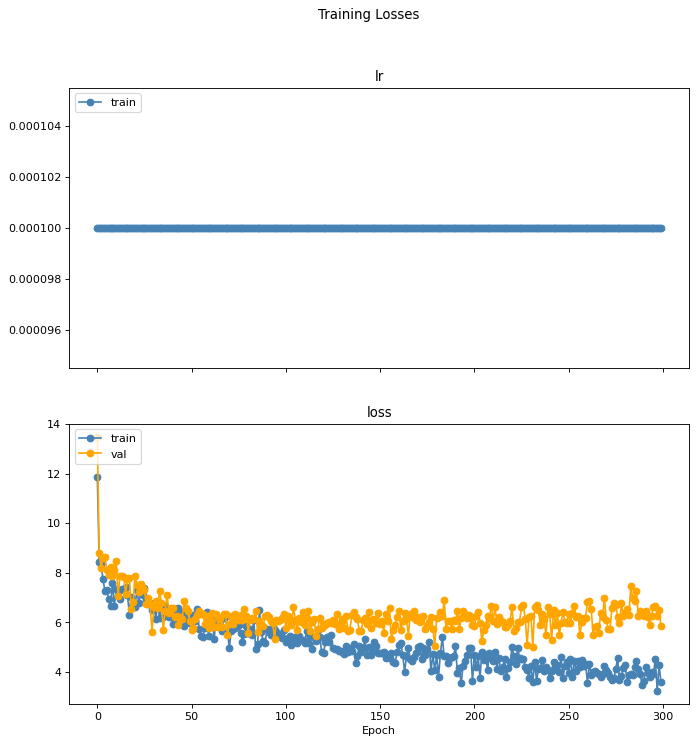

In [7]:
for t in train_infos :
    print(t)
    plot_losses(
        t.train_losses,
        t.val_losses,
    )

In [8]:
# Evaluate all train_infos on the best
from utils.checkpoint import load_checkpoints

performances = {}

for t in train_infos:
    train_info, cp = load_checkpoints(t.best_val_loss_model_path, device)
    config = train_info.config

    model, criterion, postprocessors = build_detr(
        backbone="resnet18",
        train_backbone="true",
        hidden_dim=config.model.hidden_dim,
        dilation=config.model.dilation,
        position_embedding=config.model.position_embedding,
        dropout=config.model.dropout,
        nheads=config.model.nheads,
        dim_feedforward=config.model.dim_feedforward,
        enc_layers=config.model.enc_layers,
        dec_layers=config.model.dec_layers,
        pre_norm=config.model.pre_norm,
        num_classes=len(config.dataset.label_cols),
        num_queries=config.model.num_queries,
        aux_loss=config.model.aux_loss,
        set_cost_class=config.model.set_cost_class,
        set_cost_bbox=config.model.set_cost_bbox,
        set_cost_giou=config.model.set_cost_giou,
        giou_loss_coef=config.model.giou_loss_coef,
        bbox_loss_coef=config.model.bbox_loss_coef,
        eos_coef=config.model.eos_coef,
        device=device,
    )

    # weights.
    backbone = load_backbone(config, device)
    model.backbone[0].body = backbone.body
    model.to(device)
    model.load_state_dict(cp["model"])
    model.eval()

    dataset_args = {
        "df_path": os.path.join("spreadsheets", "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    _, _, test_dataset = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXLesionDetectionDataset,
    )

    _, _, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    _, test_evaluator = evaluate(
        criterion=criterion,
        postprocessors=postprocessors,
        model=model,
        data_loader=test_dataloader,
        device=device,
        return_evaluator=True,
    )

    performance_dict = test_evaluator.compute()
    print(t)

    del performance_dict['classes']
    performance_dict = {k: v.item() for k, v in performance_dict.items()}

    print(performance_dict)

    performances[f"{config.training.name} - {config.model.name}"] = performance_dict

    with open(
        os.path.join("checkpoints", t.best_val_loss_model_path, "performance.txt"), "w"
    ) as f:
        f.write(str(t) + "\n" + "Best: \n" + str(performance_dict))

Test:  [  0/114]  eta: 0:00:25  loss: 6.5832 (6.5832)  time: 0.2266  data: 0.1951  max mem: 480
Test:  [ 10/114]  eta: 0:00:21  loss: 6.5832 (6.9451)  time: 0.2114  data: 0.1847  max mem: 480
Test:  [ 20/114]  eta: 0:00:19  loss: 6.4038 (6.4028)  time: 0.2064  data: 0.1807  max mem: 480
Test:  [ 30/114]  eta: 0:00:17  loss: 5.6669 (6.3215)  time: 0.2012  data: 0.1758  max mem: 480
Test:  [ 40/114]  eta: 0:00:15  loss: 6.0018 (6.4015)  time: 0.2014  data: 0.1759  max mem: 480
Test:  [ 50/114]  eta: 0:00:13  loss: 6.0358 (6.2412)  time: 0.2035  data: 0.1781  max mem: 480
Test:  [ 60/114]  eta: 0:00:11  loss: 5.7245 (6.1366)  time: 0.2075  data: 0.1818  max mem: 480
Test:  [ 70/114]  eta: 0:00:09  loss: 6.3854 (6.2343)  time: 0.2077  data: 0.1817  max mem: 480
Test:  [ 80/114]  eta: 0:00:07  loss: 6.4840 (6.1594)  time: 0.2106  data: 0.1846  max mem: 480
Test:  [ 90/114]  eta: 0:00:04  loss: 6.2058 (6.2154)  time: 0.2084  data: 0.1822  max mem: 480
Test:  [100/114]  eta: 0:00:02  loss: 5.

In [9]:
p_df = pd.DataFrame(performances).transpose()

In [10]:
p_df

,map,map_50,map_75,map_large,map_medium,map_per_class,map_small,mar_1,mar_10,mar_100,mar_100_per_class,mar_large,mar_medium,mar_small
lesion_detection - Random,0.030836,0.088705,0.008885,-1.0,-1.0,-1.0,0.030836,0.107124,0.186376,0.224951,-1.0,-1.0,-1.0,0.224951


In [11]:
param_dict = {}
for n, p in model.named_parameters():
    param_dict.update({n: {"#params":p.nelement()}})

In [12]:
pd.DataFrame(param_dict).transpose().sort_values("#params", ascending=False).head(20)

,#params
backbone.0.body.layer4.1.conv2.weight,2359296
backbone.0.body.layer4.1.conv1.weight,2359296
backbone.0.body.layer4.0.conv2.weight,2359296
backbone.0.body.layer4.0.conv1.weight,1179648
backbone.0.body.layer3.0.conv2.weight,589824
backbone.0.body.layer3.1.conv1.weight,589824
backbone.0.body.layer3.1.conv2.weight,589824
backbone.0.body.layer3.0.conv1.weight,294912
backbone.0.body.layer2.1.conv2.weight,147456
backbone.0.body.layer2.1.conv1.weight,147456
